# TensorFlow:最初のステップ

In [1]:
import tensorflow as tf

/home/yokota/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
# 計算グラフを作成
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w * x + b
    init = tf.global_variables_initializer()
    
## セッションを作成し，計算グラフgを渡す
with tf.Session(graph=g) as sess:
    ## wとbを初期化
    sess.run(init)
    ## zを評価
    for t in [1.0, 0.6, -1.8]:
        print('x={:4.1f} --> z={:4.1f}'.format(t, sess.run(z, feed_dict={x:t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [5]:
import numpy as np

g = tf.Graph()

with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    ## shapeに-1を指定するとテンソルを変形する際にテンソルの合計サイズと残りの次元に基づいて自動的にサイズが計算される
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')
    
    ## 各列の合計を求める
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    
    ## 各列の平均を求める
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape:{}'.format(x_array.shape))
    print('Reshaped:\n{}'.format(sess.run(x2, feed_dict={x:x_array})))
    print('Column sums:\n{}'.format(sess.run(xsum, feed_dict={x:x_array})))
    print('Column means:\n{}'.format(sess.run(xmean, feed_dict={x:x_array})))

input shape:(3, 2, 3)
Reshaped:
[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column sums:
[18. 21. 24. 27. 30. 33.]
Column means:
[ 6.  7.  8.  9. 10. 11.]


# 最小二乗線形回帰

In [6]:
# 10個のトレーニングサンプルが含まれた小さな一次元のデータセットを作成する
X_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

このデータセットを元に，入力xから出力yを予測する線形回帰モデル(TfLinreg，z=w*x+b)を実装する．

まず，このデータをモデルに供給するためのプレースホルダが2つ必要となる．

コスト関数として平均二乗誤差(MSE)を定義

重みの学習には勾配降下法のオプティマイザを使用する．

In [7]:
class TfLinreg(object):
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        ## モデルを構築
        with self.g.as_default():
            ## グラフレベルの乱数シードを設定
            tf.set_random_seed(random_seed)
            self.build()
            ## 変数のイニシャライザを作成
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        ## 入力用のプレースホルダを定義
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None), name='y_input')
        
        print(self.X)
        print(self.y)
        
        ## 重み行列とバイアスベクトルを定義
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        ## オプティマイザを作成
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate,
                    name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [8]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [9]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## 全ての変数を初期化:W, b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        ## model.optimizerとmodel.mean_costに対する演算と評価を行う
        _, cost = sess.run([model.optimizer, model.mean_cost],
                          feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
        
    return training_costs

In [10]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

In [11]:
import matplotlib.pyplot as plt

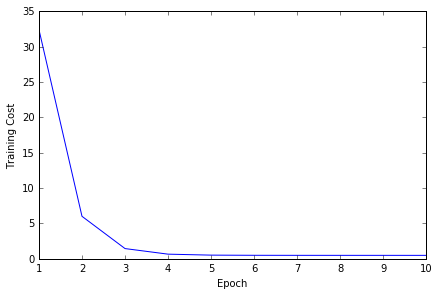

In [12]:
plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [13]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X:X_test})
    return y_pred

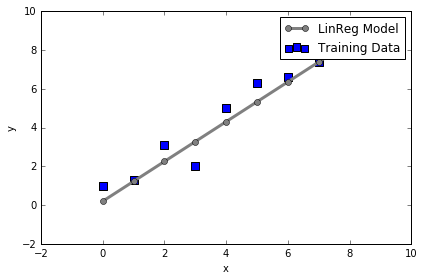

In [14]:
plt.scatter(X_train, y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]),
        predict_linreg(sess, lrmodel, X_train),
        color='gray', marker='o',
        markersize=6, linewidth=3, 
        label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()